In [292]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from common import *

%reload_ext autoreload
%autoreload 2
%matplotlib inline

def wjaccard_on_dist(a, b):
    global count
    mn = np.sum(np.minimum(a[:,0], b[:,0]))
    mx = np.sum(np.maximum(a[:,0], b[:,0]))
    return mn/mx


def l1_on_dist(a, b):
    return np.sum(np.abs(a[:, 0] - b[:, 0]))


def attach_new_metric(df):
#     new_metric = compute_metric(df, wjaccard_on_dist)
#     df['wjaccard_dist_ksim'] = new_metric[:,0]
#     df['wjaccard_dist_paa'] = new_metric[:,1]
    new_metric = compute_metric(df, l1_on_dist)
    df['l1_ksim'] = new_metric[:,0]
    df['l1_paa'] = new_metric[:,1]
    return df


# Load all datasets

In [293]:
prefix='../../results/'

all_datasets = {}
for d in all_dataset_metadata:
    df_in = attach_new_metric(read_results_file('%s/ksim_%s_0.1_results.txt' % (prefix, d['file_name'])))
    df_out = attach_new_metric(read_results_file('%s/ksim_outside_%s_0.1_results.txt' % (prefix, d['file_name'])))
    # Modify the index to avoid duplicated example identities between df_in and df_out
    df_out['ts_index'] += 10000
    all_datasets[d['file_name']] = {
        'df': combine_in_out(df_in, df_out),
        'name': d['name'],
        'size': d['size'],
        'xlim': d['xlim']
    }


# Plot metrics of a few examples

In [267]:
def quick_view_metric(df, metric, k, title='', xlim=-1):
    examples = df[['ts_index', 'ts_start', 'ts_end']].drop_duplicates()
    samples = examples.sample(12)
    dfk = df[df.k == k]
    fig, axs = plt.subplots(3, 4, figsize=(12, 7))
    axs = axs.flatten()
    fig.suptitle(title, fontsize=16)
    
    for iax, (index, row) in enumerate(samples.iterrows()):
        selector = ((dfk['ts_index'] == row['ts_index']) 
                    & (dfk['ts_start'] == row['ts_start'])
                    & (dfk['ts_end'] == row['ts_end']))
        current = dfk[selector][['h_extra', metric + '_ksim', metric + '_paa']].drop_duplicates()

        h = current['h_extra']

        metric_ksim = pd.Series(current[metric + '_ksim'].values, index=h)
        metric_paa = pd.Series(current[metric + '_paa'].values, index=h)

        metric_ksim = sort_and_clamp(metric_ksim, xlim)
        metric_paa = sort_and_clamp(metric_paa, xlim)
        
        ax = axs[iax]
        ax.ticklabel_format(style='sci', axis='x', scilimits=(0,4), useMathText='True')
        metric_ksim.plot(title='Index: %d'%index, ax=ax)
        metric_paa.plot(title='Index: %d'%index, ax=ax)


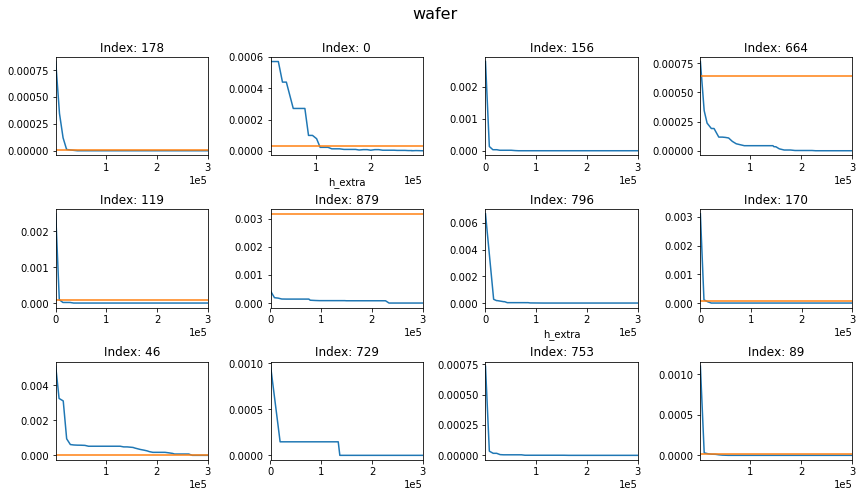

In [268]:
view_dataset = 'wafer'
quick_view_metric(all_datasets[view_dataset]['df']
                  , metric='l1'
                  , k=15
                  , title=all_datasets[view_dataset]['name']
                  , xlim=300000)
plt.tight_layout()
plt.subplots_adjust(top=0.88)

# Report function

This function reports:
1. Accuracy
2. Percent of dataset need to be sought to reach 100% accuracy

Figures are saved to file

In [301]:
markers = ['o', 'x', '^']
marker_counter = 0

def report_and_plot_by_k(df, ax, k, metric, xlim=5000, verbose=True, larger_is_better=True):
    global markers
    global marker_counter

    # Calculate average of metrics from data
    df_metric, avg_max_acc, avg_min_extent =\
        average_metric(df, metric=metric, k=k, larger_is_better=larger_is_better)
    
    # Sort and extend or shrink to fit limit
    avg_metric = sort_and_clamp(df_metric.mean(axis=1), limit=xlim)
    std_metric = sort_and_clamp(df_metric.std(axis=1), limit=xlim)

    # Do the same with PAA metrics
    paa_metric = df[df.k == k][metric + '_paa']
    paa_metric_value = paa_metric[~(paa_metric == np.inf)].mean()
    paa_metric = pd.Series(np.repeat(paa_metric_value, avg_metric.size), index=avg_metric.index)
    
    # Plot aggregated results
#     marker = markers[marker_counter]
    marker = ''
    marker_counter = (marker_counter + 1) % 3

    avg_metric.plot(label='k = %d (K-ONEX)' % k, ax=ax,
                    linewidth=2.5, marker=marker)
    most_recent_color = ax.lines[-1].get_color()
    paa_metric.plot(label='k = %d (PAA)' % k, ax=ax,
                    color=most_recent_color, linestyle='--', marker=marker)
    
    # Report in words
    if verbose:
        print 'k =', k
        print ' best accuracy: %f' % avg_max_acc, ' min extent: %d' % avg_min_extent
        print ' best PAA accuracy: %f' % paa_metric_value


def report_and_plot(df, ax, title, xlim=5000, verbose=True):
    # Set up the axis
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('$k_e$', fontsize=12)
    ax.set_ylabel('L1', fontsize=12)
    ax.ticklabel_format(axis='x', style='sci', scilimits=(-3, 4))
    
    if verbose:
        print title
    for k in [1, 9, 15]:
        report_and_plot_by_k(df, ax, k=k, metric='l1', xlim=xlim, verbose=verbose, larger_is_better=False)
    ax.legend(fontsize=10, loc='upper right')
    

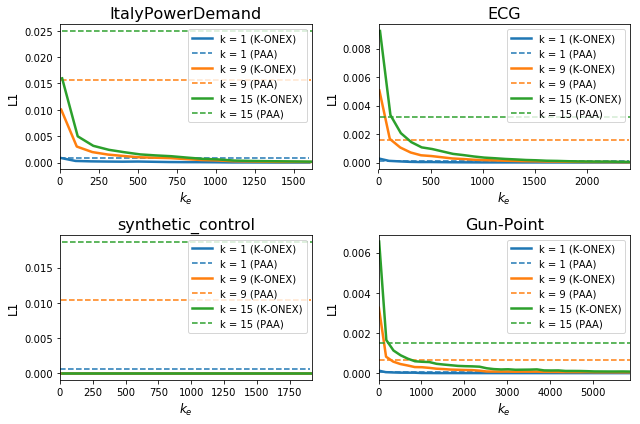

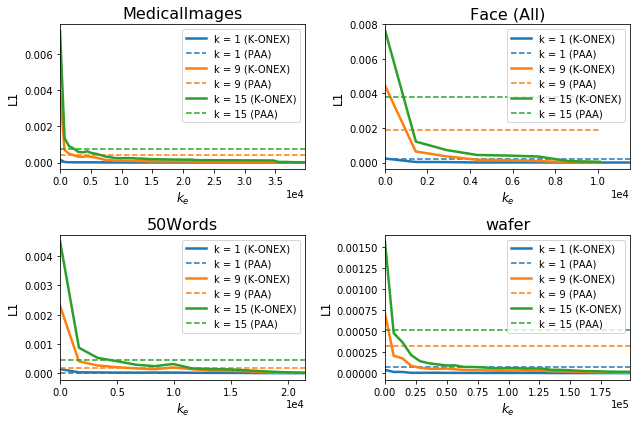

In [302]:
fig, axs = plt.subplots(2, 2, figsize=(9, 6))
axs = axs.flatten()

for i, name in enumerate(sorted_name_by_size[:4]):
    d = all_datasets[name]
    ax = axs[i]
    report_and_plot(d['df'], ax, d['name'], xlim=d['xlim'], verbose=False)
    
plt.tight_layout()
plt.savefig('accuracy_all_datasets_1.eps')

fig, axs = plt.subplots(2, 2, figsize=(9, 6))
axs = axs.flatten()

for i, name in enumerate(sorted_name_by_size[4:]):
    d = all_datasets[name]
    ax = axs[i]
    report_and_plot(d['df'], ax, d['name'], xlim=d['xlim'], verbose=False)
    
plt.tight_layout()
plt.savefig('accuracy_all_datasets_2.eps')

# ItalyPowerDemand

ItalyPowerDemand
k = 1
 best accuracy: 0.000000  min extent: 282
 best PAA accuracy: 0.000948
k = 9
 best accuracy: 0.000000  min extent: 707
 best PAA accuracy: 0.015733
k = 15
 best accuracy: 0.000000  min extent: 913
 best PAA accuracy: 0.024961


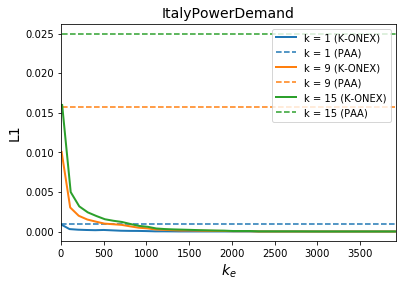

In [224]:
fig, ax = plt.subplots(1)
d =  all_datasets['ItalyPowerDemand']
report_and_plot(d['df'], ax, d['name'], xlim=d['xlim'])

# ECG200

ECG
k = 1
 best accuracy: 0.000000  min extent: 452
 best PAA accuracy: 0.000104
k = 9
 best accuracy: 0.000000  min extent: 929
 best PAA accuracy: 0.001616
k = 15
 best accuracy: 0.000000  min extent: 1048
 best PAA accuracy: 0.003216


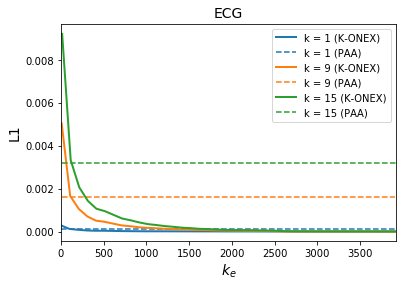

In [225]:
fig, ax = plt.subplots(1)
d =  all_datasets['ECG200']
report_and_plot(d['df'], ax, d['name'], xlim=d['xlim'])

# synthetic_control

synthetic_control
k = 1
 best accuracy: 0.000000  min extent: 1
 best PAA accuracy: 0.000572
k = 9
 best accuracy: 0.000000  min extent: 9
 best PAA accuracy: 0.010357
k = 15
 best accuracy: 0.000000  min extent: 15
 best PAA accuracy: 0.018698


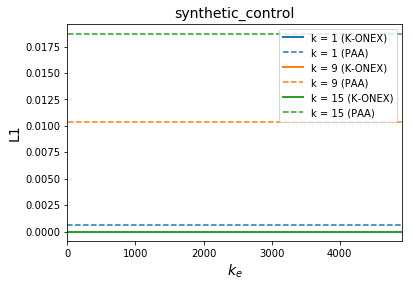

In [226]:
fig, ax = plt.subplots(1)
d =  all_datasets['synthetic_control']
report_and_plot(d['df'], ax, d['name'], xlim=d['xlim'])

# Gun-Point

Gun-Point
k = 1
 best accuracy: 0.000000  min extent: 1250
 best PAA accuracy: 0.000048
k = 9
 best accuracy: 0.000000  min extent: 2213
 best PAA accuracy: 0.000675
k = 15
 best accuracy: 0.000000  min extent: 2419
 best PAA accuracy: 0.001488


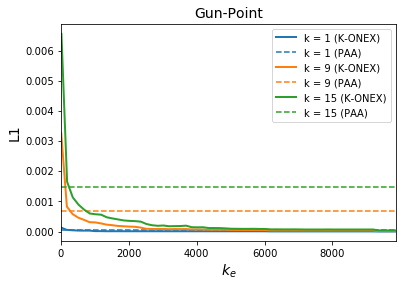

In [227]:
fig, ax = plt.subplots(1)
d =  all_datasets['Gun_Point']
report_and_plot(d['df'], ax, d['name'], xlim=d['xlim'])

# MedicalImages

MedicalImages
k = 1
 best accuracy: 0.000000  min extent: 8638
 best PAA accuracy: 0.000036
k = 9
 best accuracy: 0.000000  min extent: 12346
 best PAA accuracy: 0.000422
k = 15
 best accuracy: 0.000000  min extent: 14268
 best PAA accuracy: 0.000754


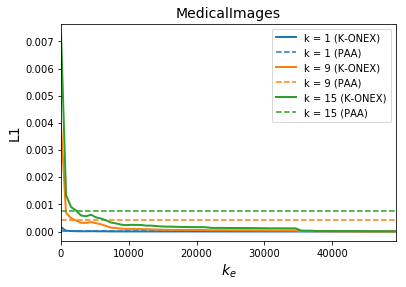

In [228]:
fig, ax = plt.subplots(1)
d =  all_datasets['MedicalImages']
report_and_plot(d['df'], ax, d['name'], xlim=d['xlim'])

# FaceAll

Face (All)
k = 1
 best accuracy: 0.000000  min extent: 2159
 best PAA accuracy: 0.000209
k = 9
 best accuracy: 0.000000  min extent: 8714
 best PAA accuracy: 0.001900
k = 15
 best accuracy: 0.000000  min extent: 9728
 best PAA accuracy: 0.003823


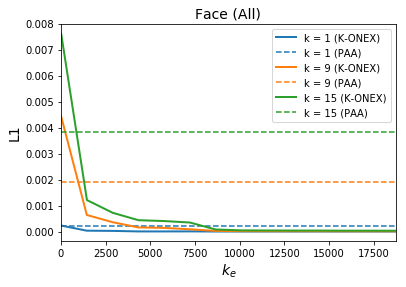

In [229]:
fig, ax = plt.subplots(1)
d =  all_datasets['FaceAll']
report_and_plot(d['df'], ax, d['name'], xlim=d['xlim'])

# 50Words

50Words
k = 1
 best accuracy: 0.000000  min extent: 7269
 best PAA accuracy: 0.000007
k = 9
 best accuracy: 0.000000  min extent: 9921
 best PAA accuracy: 0.000173
k = 15
 best accuracy: 0.000000  min extent: 11331
 best PAA accuracy: 0.000434


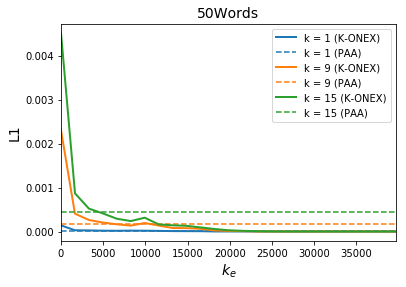

In [230]:
fig, ax = plt.subplots(1)
d =  all_datasets['50words']
report_and_plot(d['df'], ax, d['name'], xlim=d['xlim'])

# wafer

wafer
k = 1
 best accuracy: 0.000000  min extent: 76164
 best PAA accuracy: 0.000070
k = 9
 best accuracy: 0.000000  min extent: 144188
 best PAA accuracy: 0.000323
k = 15
 best accuracy: 0.000000  min extent: 171826
 best PAA accuracy: 0.000514


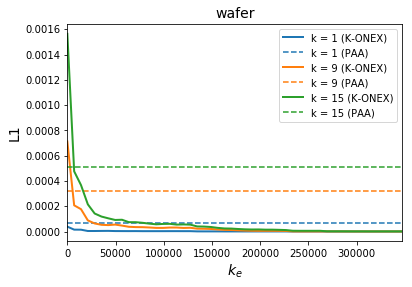

In [231]:
fig, ax = plt.subplots(1)
d =  all_datasets['wafer']
report_and_plot(d['df'], ax, d['name'], xlim=d['xlim'])